# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [36]:
# Your code here
import pandas as pd
data = pd.read_csv('data.csv').sample(100000)
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
746007,38,CASH_IN,424001.13,C1194544739,414786.98,838788.11,C553955699,1785335.33,1361334.20,0,0
1889697,165,PAYMENT,4303.60,C1375334971,101661.00,97357.40,M1867882055,0.00,0.00,0,0
4417060,322,CASH_IN,68817.22,C1480738688,1006606.72,1075423.94,C1301488744,197097.80,128280.58,0,0
5896763,403,TRANSFER,196845.97,C1639286975,0.00,0.00,C1867253997,406412.33,543194.10,0,0
861434,42,CASH_IN,22474.13,C1549124539,55542.00,78016.13,C979752978,0.00,0.00,0,0


In [37]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000,100000.0
mean,243.106560,1.788775e+05,8.429651e+05,8.641737e+05,1.099220e+06,1.222078e+06,0.001180,0.0
std,142.547094,6.680244e+05,2.907751e+06,2.942661e+06,3.193768e+06,3.473666e+06,0.034331,0.0
min,1.000000,2.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,155.000000,1.337768e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,238.000000,7.424470e+04,1.461650e+04,0.000000e+00,1.339480e+05,2.151653e+05,0.000000,0.0
75%,334.000000,2.080137e+05,1.087485e+05,1.465095e+05,9.343692e+05,1.106513e+06,0.000000,0.0
max,735.000000,9.244552e+07,3.335094e+07,3.346415e+07,1.772492e+08,1.854608e+08,1.000000,0.0


In [38]:
data.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

### What is the distribution of the outcome? 

0    99882
1      118
Name: isFraud, dtype: int64


<AxesSubplot:>

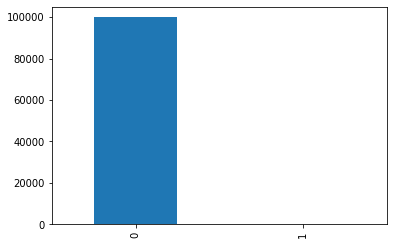

In [39]:
# Your response here
outcome = pd.value_counts(data.isFraud)
print(outcome)
outcome.plot(kind='bar')

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [40]:
# Your code here
data.drop(columns=['type', 'nameOrig', 'nameDest'], inplace=True)
data.isnull().sum()

step              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [41]:
# Step maps a unit of time in the real world. In this case 1 step is 1 hour of time.
# So yes, I think it's appropriate to have it like that.

### Run a logisitc regression classifier and evaluate its accuracy.

In [58]:
# Your code here
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

X = data.drop(columns='isFraud')
y = data.isFraud

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Oversample
train = pd.concat([X_train, y_train], axis=1)

no_fraud = train[train.isFraud == 0]
yes_fraud = train[train.isFraud == 1]

oversampled = resample(yes_fraud, replace=True, n_samples=len(no_fraud), random_state=0)

train_oversampled = pd.concat([no_fraud, oversampled])

y_train_oversampled = train_oversampled.isFraud.copy() 
X_train_oversampled = train_oversampled.drop(columns='isFraud').copy()

LR = LogisticRegression(max_iter=1000).fit(X_train_oversampled, y_train_oversampled)

y_pred = LR.predict(X_test)
print(classification_report(y_test, y_pred)) # recall 100% ?

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     24967
           1       0.02      1.00      0.05        33

    accuracy                           0.95     25000
   macro avg       0.51      0.97      0.51     25000
weighted avg       1.00      0.95      0.97     25000



### Now pick a model of your choice and evaluate its accuracy.

In [59]:
# Your code here
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=2).fit(X_train_oversampled, y_train_oversampled)

y_pred = tree.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     24967
           1       0.01      0.94      0.03        33

    accuracy                           0.92     25000
   macro avg       0.51      0.93      0.49     25000
weighted avg       1.00      0.92      0.96     25000



### Which model worked better and how do you know?

In [44]:
# Your response here
# Decision tree was better. We have lower accuracy but recall is a lot better

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.